## Assignment 3 - RNN

### Dragos Spiridon, Erasmus Student




# 1. Read dataset and data cleaning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/appliances+energy+prediction/AirQualityUCI.csv",sep=";", decimal=",")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


A bit of data cleaning

In [ ]:
df = df.drop(columns = ["Unnamed: 15", "Unnamed: 16"])
df = df[:9357]
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


And now select our interest columns only:


In [ ]:
data_df = df[["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)",	"PT08.S5(O3)", "C6H6(GT)"]]

data = data_df.to_numpy().reshape(-1)
len(data[data == -200])

2196

We observe that there are undefined values in these columns. We will copy-paste the code from the first assignment to just make the mean between the dates or use the previous day.

In [ ]:
df = data_df # too lazy to change all the variables to data_df

# taking the columns and removing date and time
df_columns = df.columns

df_mean = df[df_columns].copy()

# if one element is nan and the others between it are not nan
df_mean[(df_mean == -200.0) & (df_mean.shift(-1) != -200.0)  & (df_mean.shift(1) != -200.0)] = (df_mean.shift(-1) + df_mean.shift(1)) / 2

df[df_columns] = df_mean

# if there are several nans in a row, get the same value from the previous day andthe same hour
# it is clearly that we will edit all nans values from now, as the lonely ones were modified before

df_24_hours_value = df[df_columns].copy()
# doesn't work, the values are not taken consecutively
# df_24_hours_value[df_24_hours_value[df_columns] == -200.0] = df_24_hours_value.shift(24)
for col in df:
  for row in df.index:
    if row >= 24 and df[col][row] == -200.0:
      df[col][row]= df[col][row-24]


Streaming output truncated to the last 5000 lines.
<ipython-input-172-d3c468135336>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row]= df[col][row-24]
<ipython-input-172-d3c468135336>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row]= df[col][row-24]
<ipython-input-172-d3c468135336>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row]= df[col][row-24]
<ipython-input-172-d3c468135336>:22: SettingWithC

In [ ]:
data = data_df.to_numpy().reshape(-1)
len(data[data == -200])

0

No more -200 !!!

#2. Creating our RNN model

For this task, we will go with an RNN made with LTSM blocks.

In [ ]:
class MyRNN(nn.Module):
  def __init__(self, input = 5, hidden = 20, output=1):
    # we will need the variable input, because we would like to test it further
    super(MyRNN, self).__init__()
    self.input = input
    self.hidden = hidden
    self.output = output
    self.my_LSTM = nn.LSTM(input, hidden, num_layers=2, batch_first=True) # temporarily we would like to work only with one LSTM

    self.hidden2value = nn.Linear(hidden, output)

  def forward(self, x):
    x, _ = self.my_LSTM(x)
    x = self.hidden2value(x)

    return x

Test it with a random example

In [ ]:
model = MyRNN(1)

y = torch.Tensor(data_df.to_numpy())

o = model(y[:12, :1])

o.shape, y[:12, :1].shape

(torch.Size([12, 1]), torch.Size([12, 1]))

Well, with this output, everything seems to work well! We have our output as we want, now, we only have to make our dataset, dataloader, and try some experiments with it!

# 4. Using the RNN for predicting C6G6 with the PT08's

For the first input in our RNN, we will use the 5 five columns which are represented by the PT08, and we will try to predict the C6H6 column.

For this, we will make a custom dataset

In [ ]:
class PT08Dataset(Dataset):
  def __init__(self, df, separator=24, lag=1):
    self.df = df
    self.separator = separator
    self.lag = lag
    if lag == -1:
      self.lag = separator

  def __len__(self):
    return (len(self.df) - self.separator) // self.lag + 1

  def __getitem__(self, idx):
    idx_down = idx * self.lag
    idx_up = (idx_down + self.separator if idx_down + self.separator <= len(self.df) else len(self.df)) - 1

    return df.loc[idx_down:idx_up, df.columns != 'C6H6(GT)'].to_numpy(dtype=np.float32), df.loc[idx_down:idx_up, 'C6H6(GT)'].to_numpy(dtype=np.float32)

In [ ]:
# ss = StandardScaler()

# PT08_data_df = pd.DataFrame(ss.fit_transform(data_df.to_numpy()), columns=data_df.columns)

PT08_data_df = data_df

PT08_dataset = PT08Dataset(PT08_data_df)

idx = 0
PT08_dataset[idx][0].shape, PT08_dataset[idx][1].shape, len(PT08_dataset)

((24, 5), (24,), 9334)

Ok, let's split the dataset 80/20, standard scale it, and train it.

In [ ]:
PT08_training_data, PT08_test_data = train_test_split(PT08_dataset, test_size=0.2, random_state=42)

PT08_train_dataloader = DataLoader(PT08_training_data, batch_size=16, shuffle=True)
PT08_test_dataloader = DataLoader(PT08_test_data, batch_size=16, shuffle=True)

(len(PT08_train_dataloader), len(PT08_training_data)), (len(PT08_test_dataloader), len(PT08_test_data))

((467, 7467), (117, 1867))

In [ ]:
PT08_model = MyRNN(input=5)
learning_rate = 1e-3
epochs = 201
loss_fn = nn.MSELoss()
opt = optim.Adam(PT08_model.parameters(), lr=learning_rate)

In [ ]:
train_loss_list = []
test_loss_list = []

for i in range(epochs):
  train_avg_loss = 0.0
  test_avg_loss = 0.0

  PT08_model.train()
  for input, output in PT08_train_dataloader:

    PT08_model.zero_grad()
    pred = PT08_model(input)
    pred = pred.squeeze()

    loss = loss_fn(output, pred)
    loss.backward()
    train_avg_loss += loss.detach().numpy()
    opt.step()

  PT08_model.eval()
  with torch.no_grad():
    for input, output in PT08_test_dataloader:
      pred = PT08_model(input)
      pred = pred.squeeze()

      loss = loss_fn(output, pred)
      test_avg_loss += loss.detach().numpy()

  train_loss_list.append(train_avg_loss / len(PT08_train_dataloader))
  test_loss_list.append(test_avg_loss / len(PT08_test_dataloader))
  if i % 20 == 0:
    print("Loss for epoch {}: {}".format(i, train_avg_loss / len(PT08_train_dataloader)))

Loss for epoch 0: 85.13146763133798
Loss for epoch 20: 4.957177818204402
Loss for epoch 40: 4.575293476627522
Loss for epoch 60: 4.126744281556418
Loss for epoch 80: 3.080801760359035
Loss for epoch 100: 1.4027813792994497
Loss for epoch 120: 1.0243652958813776
Loss for epoch 140: 1.0239755700818987
Loss for epoch 160: 0.6987086276681316
Loss for epoch 180: 0.6921406428168111
Loss for epoch 200: 0.7421702525600377


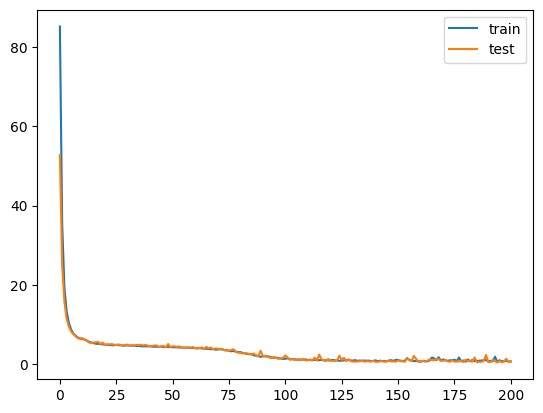

In [ ]:
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.show()

A plot with the entire time series from test and trasnforming the entire input from test with our model (because we use recurrent networks the sequence length doesn't matter, and as long as we use something like LSTM, the gates help us make long predictions without losing important information)

We observe that the flow of the predictions corresponds with the flow of the ouput, but we observe that some values are either too high or too low corresponding with the ground truth. Still, between 20 and 5 the predictions are awesome

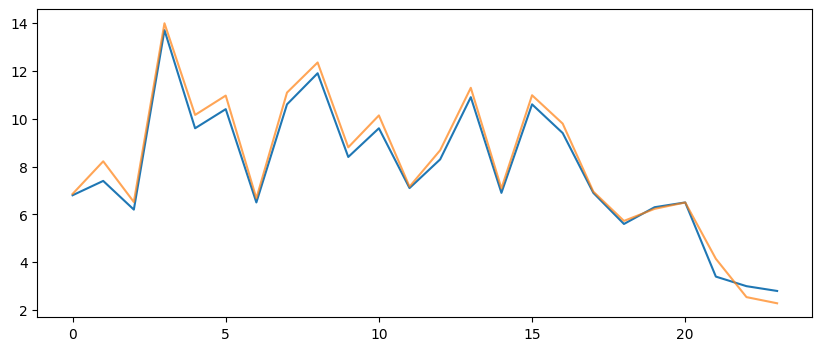

In [ ]:
idx = 54

with torch.no_grad():
  input = PT08_model(torch.Tensor(PT08_test_data[idx][0])).detach().numpy()
output = PT08_test_data[idx][1]
plt.figure(figsize=(10,4))
plt.plot(output)
plt.plot(input, alpha=0.7)
plt.show()

With this sequence for a test prediction, it is clearly that it did an awesome prediction.


Now we will continue with the second part of the assignment, by using the previous value of C6H6 column

# 5. Using the RNN for predicting C6H6 with the previous value

For this task, we will again make a custom dataset, but a bit different from the other.

In [ ]:
class C6H6Dataset(Dataset):
  def __init__(self, df, separator=24, lag=1):
    self.df = df
    self.separator = separator
    self.lag = lag
    if lag == -1:
      self.lag = self.separator

  def __len__(self):
    return (len(self.df) - self.separator) // self.lag

  def __getitem__(self, idx):
    idx_down = idx * self.lag
    idx_up = (idx_down + self.separator if idx_down + self.separator <= len(self.df) else len(self.df)) - 1

    return df.loc[idx_down:idx_up, ['C6H6(GT)']].to_numpy(dtype=np.float32), df.loc[idx_down+1:idx_up+1, 'C6H6(GT)'].to_numpy(dtype=np.float32)

We will do the same operations as above, only changing the model variables

In [ ]:
ss = StandardScaler()

C6H6_data_df = pd.DataFrame(ss.fit_transform(data_df.to_numpy()), columns=data_df.columns)

# C6H6_data_df = data_df

C6H6_dataset = C6H6Dataset(C6H6_data_df)

C6H6_training_data, C6H6_test_data = train_test_split(C6H6_dataset, test_size=0.2, random_state=42)

C6H6_train_dataloader = DataLoader(C6H6_training_data, batch_size=64, shuffle=True)
C6H6_test_dataloader = DataLoader(C6H6_test_data, batch_size=64, shuffle=True)

(len(C6H6_train_dataloader), len(C6H6_training_data)), (len(C6H6_test_dataloader), len(C6H6_test_data))

((117, 7466), (30, 1867))

In [ ]:
C6H6_model = MyRNN(input=1)
learning_rate = 1e-3
learning_rate_decays = []
epochs = 201
loss_fn = nn.MSELoss()
opt = optim.Adam(C6H6_model.parameters(), lr=learning_rate)

In [ ]:
train_loss_list = []
test_loss_list = []

In [ ]:
for i in range(epochs):
  train_avg_loss = 0.0
  test_avg_loss = 0.0
  if i in learning_rate_decays:
    for group in opt.param_groups:
      group['lr'] /= 10
  C6H6_model.train()
  for input, output in C6H6_train_dataloader:

    C6H6_model.zero_grad()
    pred = C6H6_model(input)
    pred = pred.squeeze()
    loss = loss_fn(output, pred)
    loss.backward()
    train_avg_loss += loss.detach().numpy()
    opt.step()

  C6H6_model.eval()
  with torch.no_grad():
    # validation will be only the first half of the test
    for input, output in C6H6_test_dataloader:
      pred = C6H6_model(input)
      pred = pred.squeeze()

      loss = loss_fn(output, pred)
      test_avg_loss += loss.detach().numpy()

  train_loss_list.append(train_avg_loss / len(C6H6_train_dataloader))
  test_loss_list.append(test_avg_loss / (len(C6H6_test_dataloader) // 2))
  if i % 20 == 0:
    print("Avg val Loss for epoch {}: {}".format(i, test_avg_loss / (len(C6H6_test_dataloader) // 2)))

Avg val Loss for epoch 0: 174.6817189534505
Avg val Loss for epoch 20: 24.854967625935874
Avg val Loss for epoch 40: 20.332608477274576
Avg val Loss for epoch 60: 19.22826935450236
Avg val Loss for epoch 80: 18.570676835378013
Avg val Loss for epoch 100: 18.076291211446126
Avg val Loss for epoch 120: 17.772156111399333
Avg val Loss for epoch 140: 17.42381607691447
Avg val Loss for epoch 160: 17.015325578053794
Avg val Loss for epoch 180: 16.600501124064127
Avg val Loss for epoch 200: 16.486553605397543


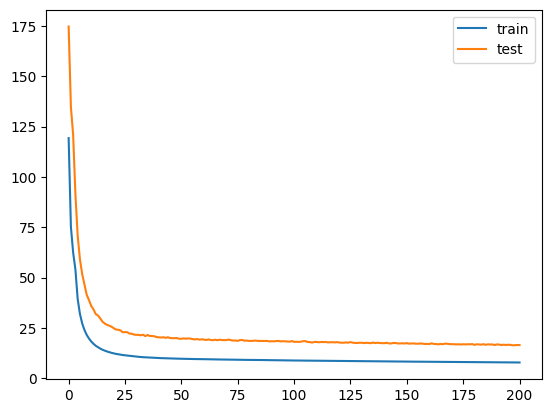

In [ ]:
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.show()

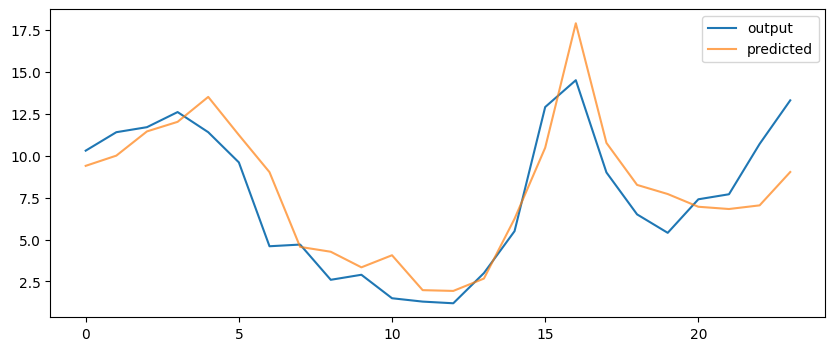

In [ ]:
idx = 65

with torch.no_grad():
  preds = C6H6_model(torch.Tensor(C6H6_test_data[idx][0])).detach().numpy()
output = C6H6_test_data[idx][1]
plt.figure(figsize=(10,4))
plt.plot(output, label="output")
plt.plot(preds, alpha=0.7, label="predicted")
plt.legend()
plt.show()

With a higher loss than the previous one, this model goes in the same direction as the ground truth, but the values have an error of 0.25 approximately from what is seen in the picture above, which is high considering the other model visualisation on a test.

# 6. Metrics and comparison between these two models

We will start by calculating the metric for each of the sequences we got. For the entire time series, and from ones which are only on test. We will calculate the mean squared error and mean absolute error (MSE and MAE) for the entire sequences. We already have a small idea on what is the result of MSE by the loss of the model.

Metrics for test data: 

Average PT08 columns MSE: 0.7204311856856713
Average PT08 columns MAE: 0.49920021443285495
Average PT08 columns RMSE: 0.8098843907698606

Average C6H6 Previous value MSE: 8.313529125849406
Average C6H6 Previous value MAE: 1.94435719648997
Average C6H6 Previous value MAE: 2.880134121576945


Metrics for the entire sequence:

Average PT08 columns MSE: 0.3511948
Average PT08 columns MAE: 0.41050342
Average PT08 columns RMSE: 0.5926169

Average C6H6 Previous value MSE: 6.2886043
Average C6H6 Previous value MAE: 1.7352306
Average C6H6 Previous value RMSE: 2.507709


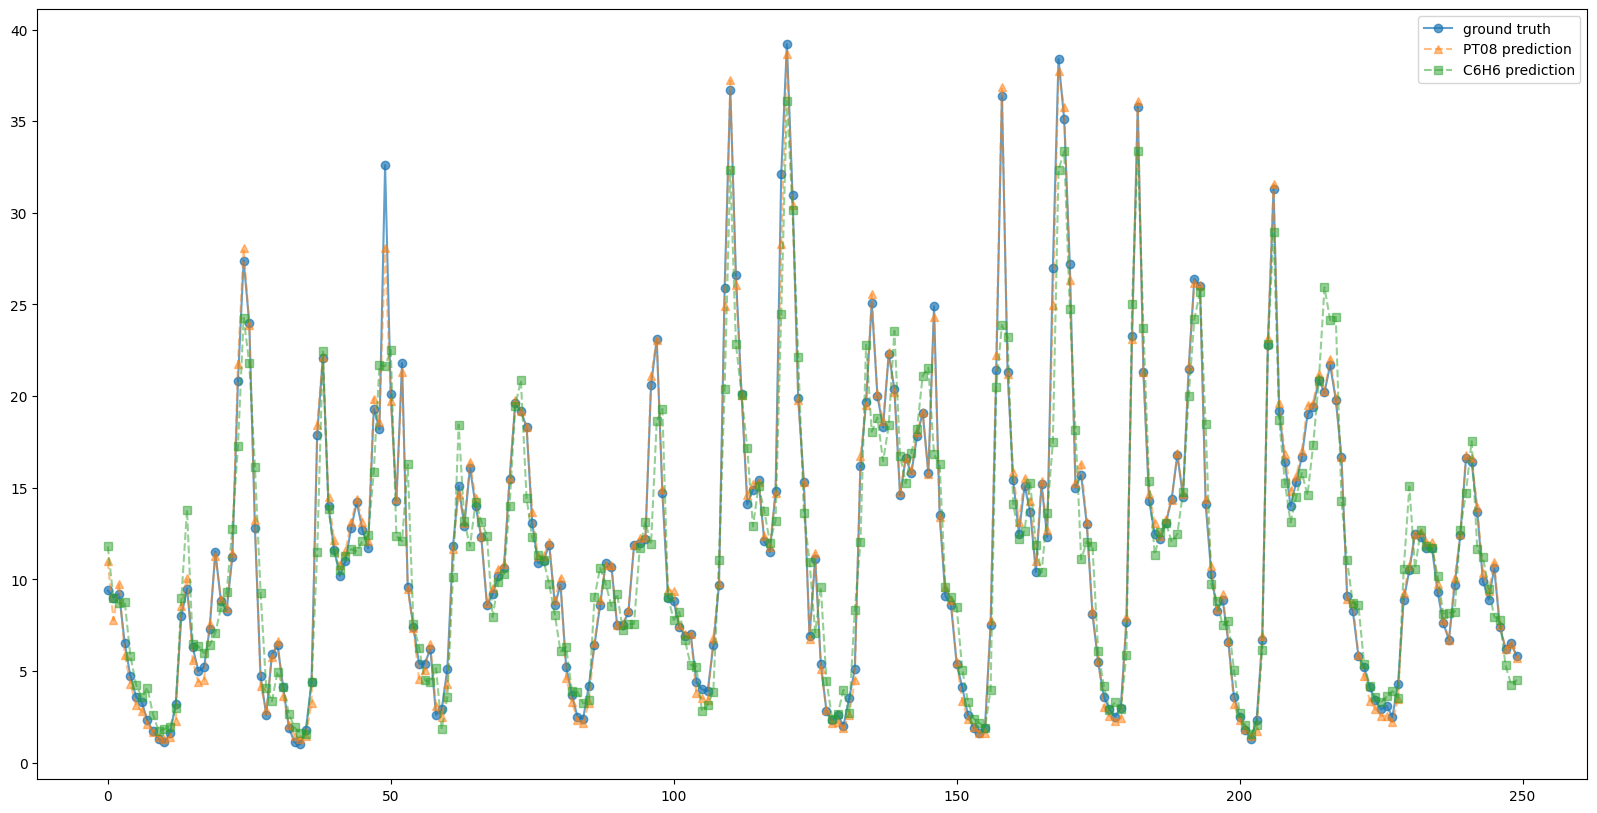

In [ ]:
with torch.no_grad():
  # for the test of each one of them
  PT08_mse = []
  C6H6_mse = []
  PT08_mae = []
  C6H6_mae = []
  PT08_rmse = []
  C6H6_rmse = []

  for input, output in PT08_test_dataloader:
      pred = PT08_model(input)
      pred = pred.squeeze().reshape(-1)

      output = output.reshape(-1)
      PT08_mse.append(mean_squared_error(pred, output))
      PT08_mae.append(mean_absolute_error(pred, output))
      PT08_rmse.append(mean_squared_error(pred, output, squared=False))


  for input, output in C6H6_test_dataloader:
      pred = C6H6_model(input)
      pred = pred.squeeze().reshape(-1)

      output = output.reshape(-1)
      C6H6_mse.append(mean_squared_error(pred, output))
      C6H6_mae.append(mean_absolute_error(pred, output))
      C6H6_rmse.append(mean_squared_error(pred, output, squared=False))
  print("Metrics for test data: \n")
  print("Average PT08 columns MSE:", sum(PT08_mse) / len(PT08_mse))
  print("Average PT08 columns MAE:", sum(PT08_mae) / len(PT08_mae))
  print("Average PT08 columns RMSE:", sum(PT08_rmse) / len(PT08_rmse))
  print()
  print("Average C6H6 Previous value MSE:", sum(C6H6_mse) / len(C6H6_mse))
  print("Average C6H6 Previous value MAE:", sum(C6H6_mae) / len(C6H6_mae))
  print("Average C6H6 Previous value MAE:", sum(C6H6_rmse) / len(C6H6_rmse))

  # for the entire sequence
  # we would like to have the same output for both of them, so we will predict
  # from the perspective of PT08 all of the sequence except the first value
  # and from the previous value of C6H6 we will predict all values except the
  # last one
  PT08_input = data_df.loc[1:, df.columns != 'C6H6(GT)'].to_numpy(dtype=np.float32)
  C6H6_input = data_df.loc[:len(data_df) - 2, ['C6H6(GT)']].to_numpy(dtype=np.float32)

  output = torch.Tensor(data_df.loc[1:, 'C6H6(GT)'].to_numpy(dtype=np.float32))

  PT08_pred = PT08_model(torch.Tensor(PT08_input))
  PT08_pred = PT08_pred.squeeze().reshape(-1)

  print("\n\nMetrics for the entire sequence:\n")
  output = output.reshape(-1)
  print("Average PT08 columns MSE:", mean_squared_error(PT08_pred, output))
  print("Average PT08 columns MAE:", mean_absolute_error(PT08_pred, output))
  print("Average PT08 columns RMSE:", mean_squared_error(PT08_pred, output, squared=False))
  print()
  C6H6_pred = C6H6_model(torch.Tensor(C6H6_input))
  C6H6_pred = C6H6_pred.squeeze().reshape(-1)

  output = output.reshape(-1)
  print("Average C6H6 Previous value MSE:", mean_squared_error(C6H6_pred, output))
  print("Average C6H6 Previous value MAE:",mean_absolute_error(C6H6_pred, output))
  print("Average C6H6 Previous value RMSE:", mean_squared_error(C6H6_pred, output, squared=False))

  plt.figure(figsize=(20,10))
  limit_down = 0
  limit_up = 250
  plt.plot(output[limit_down:limit_up], "o-", label="ground truth", alpha=0.7)
  plt.plot(PT08_pred[limit_down:limit_up], "^--", label="PT08 prediction", alpha=0.5)
  plt.plot(C6H6_pred[limit_down:limit_up], "s--", label="C6H6 prediction", alpha=0.5)
  plt.legend()
  plt.show()

Taking the test sequences and evaluating them, it is clearly observable that our first RNN model which uses the PT08 columns have a better prediction than the one which uses the previous value from ground truth column (C6H6(GT)). The Mean Squared error metric havs a high difference between the models, which makes sense as MSE is sensitive to outliers, and so the second model has more outliers in the prediction rather than the first model.

Something worth mentioning for the first model results is that even if MSE is lower than 1, it is actually higher than MAE, which means that there are results with a difference bigger than one, which means that this model provides outliers, even though it has good metrics results.

For the entire sequence as input, the results were obvious in terms of the previous results: the first model do a better job than the second model.

In the image presented above, it can be observed in the highest values from the sequence that the PT08 prediction actually is really close to the ground truth, and the prediction from the second model does grow up, but not enough to achieve that closeness between the points.

# 7. Personal considerations

 - it is much harder to train the RNN for only a single value and also get good results. Maybe another solution wouldhave been to forcefully trying to predict 5 previous values of C6H6 instead of only one, but I am not 100% sure if this is a good idea. I tried with learning decay, different sizes for hidden layers, more LTSMs one after another (it has a parameter 'num_layers' for that) but nothing worked. Most probably I have to change the model entirely for that problem.
 - really nice that I made in the first midterm the assignment using this dataset and it was really easy to incorporate the data-cleaning and data preprocessing :D
 -  Long Short Term Memory is a really wonderful RNN, which really achives great results, with such a simple implementation. The LSTM from PyTorch also has an interesting feature called "proj_size" which transform the hidden layer from the output to the size want, but after receiving some warnings and reading stuff about the parameter, it is not really quite good, and it would be better if you put the hidden layer output to a feed-forward network and obtain the desired output (also helps for better learning the weights).
 - for the experiments, which will not be presented in this notebook because there were a lot of them, firstly I tried training with entirely different sequences, and taking different 24 hours from the dataset (meaning that the lag was equal to 24). After some readings (again), I found out that it is much more sustainable if the dataset is taken with a lag of equal 1. In this way, the dataset is much larger, and the predictions actually improved a lot. Another experiment I tried was standard scaling the data, but somehow it got worse results. I cannot explain to myself how can this happen, but in anycase, I kept the results without normalizing the data.
 - it is amazing how much work is already done by libraries for AI and how easily they can be used